In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

In [2]:
def project_and_calc_dist(X,Y,theta,p):
    x_proj = np.dot(X, theta.T)
    y_proj = np.dot(Y, theta.T)
    qs = np.linspace(0,1,100)
    xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
    yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")
    dist_p = np.abs(xp_quantiles - yp_quantiles)**p
    return dist_p


def sample_theta(X,num_smaples=10):
    _ , d = X.shape
    theta = np.random.randn(num_smaples,d)
    theta_norm = np.linalg.norm(theta, axis=1)
    theta_normed = theta / theta_norm[:, np.newaxis]
    return theta_normed


def mom_estimates(X):
    mean_X = np.mean(X)
    var_X = np.var(X, ddof=1)
    alpha_hat = mean_X**2 / var_X
    beta_hat = mean_X/var_X
    return alpha_hat, beta_hat


In [206]:
mu = np.zeros(784)
cov = np.eye(784)


Y = pd.DataFrame(np.random.multivariate_normal(mu,cov,1000))


In [207]:
data = pd.read_csv("C:/Users/Sven Jacob/Documents/Github/SWDCPD/ChangeDetection/DATA.csv")

X = data.iloc[:100,1:]*255
#Y = data.iloc[200:400,1:]*255

In [208]:
THETA = sample_theta(X,50000)
x_proj = np.matmul(X,THETA.T)
y_proj = np.matmul(Y,THETA.T)
qs = np.linspace(0,1,100)
xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")

$\langle X_{i},\theta \rangle \sim \mathcal{N}$



In [187]:
x_proj.iloc[1,:].var()

10127.656319316891

In [211]:
print((np.diag(Y.cov()).sum()+np.linalg.norm(Y.mean(axis=0)))/784)
y_proj.var().mean()

1.0037923232571597


1.0025399764997407

In [212]:
y_proj.mean().mean()

-0.00017469492815371229

<Axes: ylabel='Density'>

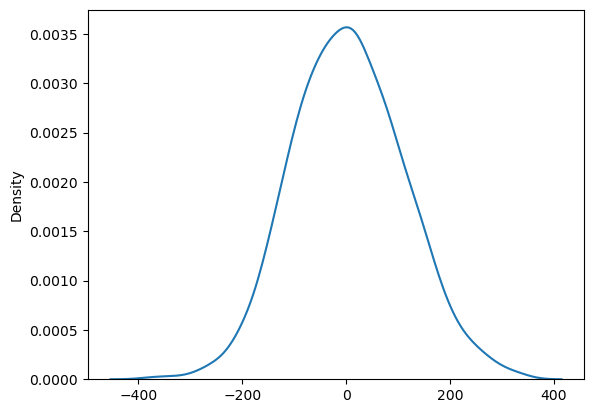

In [155]:
sns.kdeplot(np.random.normal(x_proj.iloc[0,:].mean(),x_proj.iloc[0,:].std(),1000))

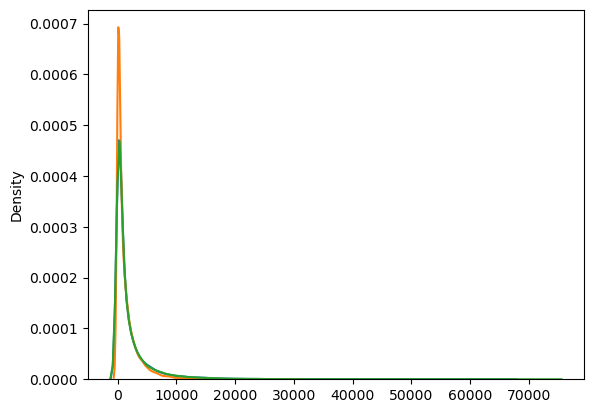

In [156]:
for i in [0,50,99]:
    sns.kdeplot(np.abs(xp_quantiles[i,:]-yp_quantiles[i,:])**2)

<Axes: ylabel='Density'>

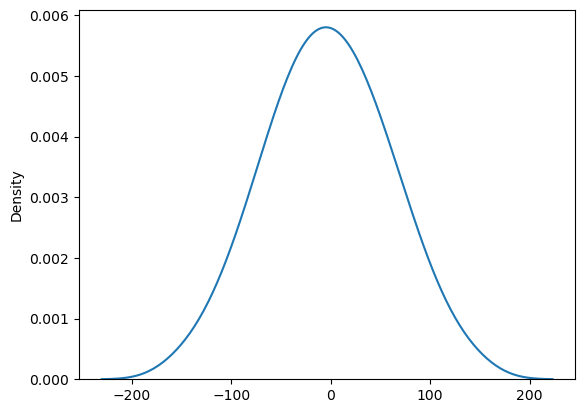

In [126]:
sns.kdeplot(xp_quantiles.mean(axis=1))

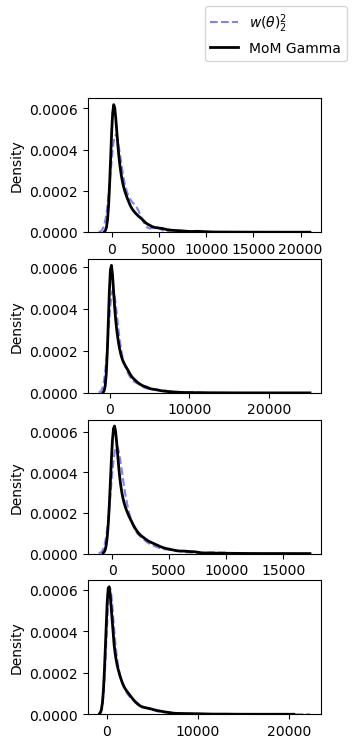

In [168]:


fig, ax = plt.subplots((4),figsize=(3,8))
col = 0
for N in [100,500,1000,5000]:
    THETA = sample_theta(X,N)
    w2 = project_and_calc_dist(X,Y,THETA,2).mean(axis=0)
    if N ==100:
        sns.kdeplot(w2,color='blue',alpha=0.5,ax=ax[col],label='$w(\\theta)_{2}^{2}$',ls='--')
    else:
        sns.kdeplot(w2,color='blue',alpha=0.5,ax=ax[col],ls='--')
    col+=1
a_hat, b_hat = mom_estimates(w2)
sns.kdeplot(np.random.gamma(a_hat,1/b_hat,10000),ax=ax[0],label='MoM Gamma',lw=2,color='black')

for col in range(1,4):
    sns.kdeplot(np.random.gamma(a_hat,1/b_hat,10000),ax=ax[col],lw=2,color='black')
fig.legend()
# THETA = sample_theta(X,1000)
# w2 = project_and_calc_dist(X,Y,THETA,2).mean(axis=0)

#a_hat, b_hat = mom_estimates(w2)

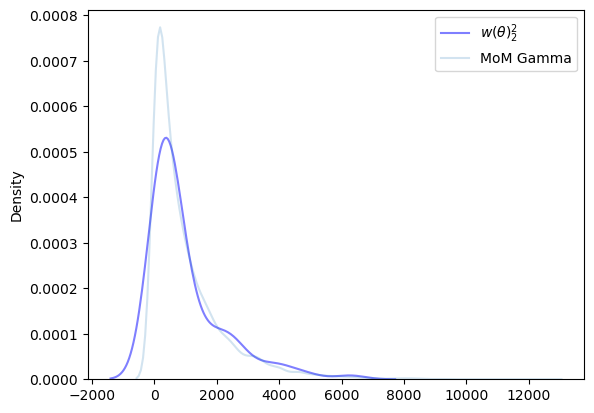

In [32]:
fig, ax = plt.subplots()
sns.kdeplot(w2,color='blue',alpha=0.5,ax=ax,label='$w(\\theta)_{2}^{2}$')
sns.kdeplot(np.random.gamma(a_hat,1/b_hat,10000),alpha=0.2,ax=ax,label='MoM Gamma')
ax.legend()

